In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch import nn, optim, cat
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import spacy
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Loading and Configurations for Use later
nltk.download('stopwords')
nlp = spacy.load("en_core_web_lg")
punctuation = string.punctuation.replace("#", "")

plt.style.use('fivethirtyeight')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Natural Language Processing with Disaster Tweets

## Introduction
- In this notebook we will be fine-tuning a BERT model to create a sort of BERT-Based Hybrid Classifier. From the given text data we will extract insightful numeric features to enrich our Classifier with. This notebook will cover a lot of different techniques used for this competition. I will be omitting a lot of technical details so you should be some-what familiar with PyTorch and BERT to understand.

## Table of Contents
   - [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
   - [Data Preprocessing](#Data-Preprocessing)
       - [Feature Engineering](#Feature-Engineering)
       - [Text Preprocessing](#Text-Preprocessing)
       - [Scaling](#Scaling)
   - [Model Building](#Model-Building)
       - [Choosing the Right Model](#Choosing-the-Right-Model)
       - [PyTorch Dataset and BERT Tokenizer](#PyTorch-Dataset-and-BERT-Tokenizer)
       - [Data Splitting and Data Loading](#Data-Splitting-and-Data-Loading)
       - [Choosing Right Sequence Length and Batch Size](#Choosing-Right-Sequence-Length-and-Batch-Size)
       - [Model Architecture](#Model-Architecture)
       - [Model Parameters, Loss Function and Optimizer](#Model-Parameters,-Loss-Function-and-Optimizer)
       - [Submission](#Submission)


## Exploratory Data Analysis
- This will be a brief look into our dataset because it contains very little features. We should keep in mind we are dealing with tweets as our source. The goal is to identify which of the tweets are natural disasters. Our model is designed to discern whether a tweet genuinely pertains to a disaster, such as 'Wholesale Markets ablaze,' or is misleading, like 'Crying out for more! Set me ablaze.'. So we should be mindful of what features a misleading tweet or truthful tweet might have.

[🔝](#Table-of-Contents)

In [2]:
df = pd.read_csv('train.csv')
df_submit = pd.read_csv('test.csv')

In [3]:
df.head(50)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Ran a large preview of the dataset here just to look through it. Let's start with our features, already we can tell we might be dealing with a lot of missing values. We can also see that the location column has a lot of noisy locations such as 'Milky Way' repeated. We can investigate that in the following cells alongside the other features.

As for the text column which will is the main focus for the classification. We can see a lot of hashtags, some urls, some ats amongst other patterns. This will be important later when we discuss common feature engineering techniques.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We notice the shape of our dataset is (7613, 5). This is relatively small dataset for fine-tuning a BERT model.

In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We can see location is very incomplete. Keyword only has a few missing values is relatively easy to impute the values with NLP techniques. You could utilize Named Entity Recognition to extract the keywords from the text.

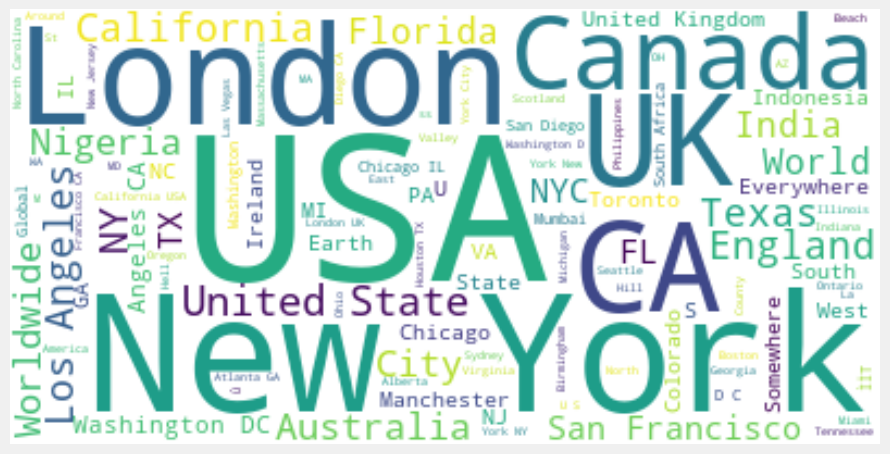

In [6]:
text = ' '.join(location for location in df['location'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that the column isn't as noisy as originally thought and it could be valuable insight. I have chosen to ommit this column but will consider it for future iterations. It is typical to drop this column since these are user set locations and can be unreliable, as well as the incompelteness.

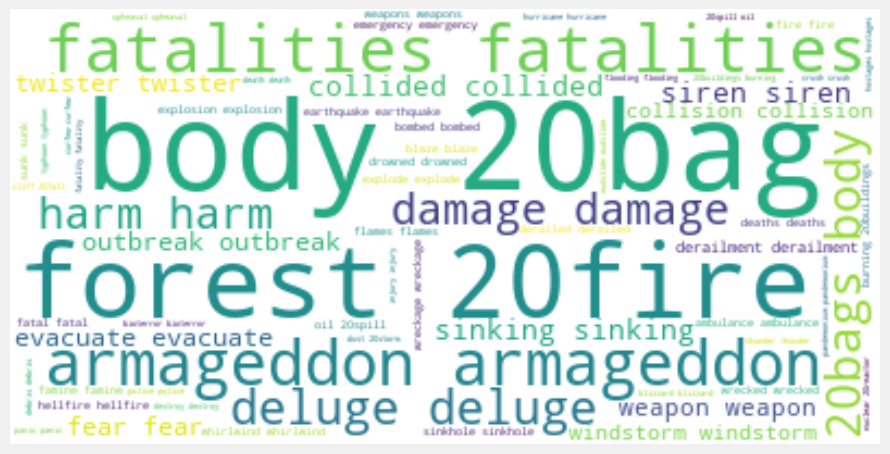

In [7]:
text = ' '.join(location for location in df['keyword'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Keyword does seem to be a valuable column however it is very noisy and needs additional help. I've seen it paired with other techniques (sentiment analysis, synonym expansion) for additional context. We will be omitting this for now.

The last part of our brief analysis will to check if our data is balanced. This is important for mitigating a class bias.

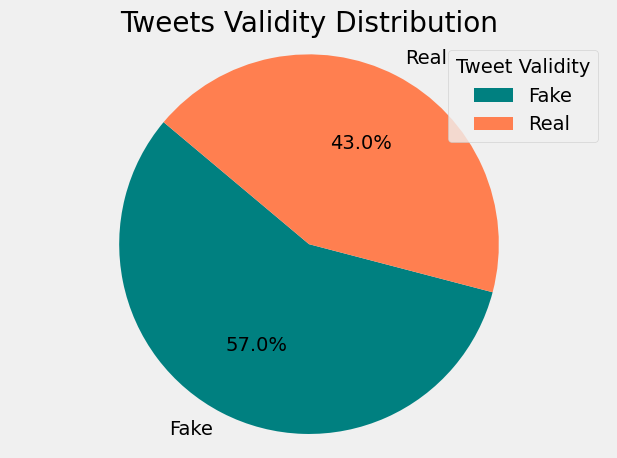

In [8]:
target_counts = df['target'].value_counts()
labels = ['Real' if index==1 else 'Fake' for index in target_counts.index]
colors = ['teal', 'coral']

fig, ax = plt.subplots()
target_counts.plot(kind='pie', labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, ax=ax)

ax.legend(labels, title="Tweet Validity")
ax.set_title('Tweets Validity Distribution')
ax.set_ylabel('')
ax.axis('equal')

plt.tight_layout()
plt.show()


We can see our dats is fairly balanced and will be acceptable for our model.

## Data Preprocessing
- In this section we will start by doing some popular feature engineering steps to help capture some relationships. These will provide a series of numeric features that we will combine with our BERT model for the best results. We will also apply a series of preprocessing techniques to the text column. There which preprocessing techniques are ideal for BERT.

[🔝](#Table-of-Contents)

### Feature Engineering
In the following code segment we will be creating the following features with the corresponding assumptions.
- Word Count - real tweets have higher word counts
- Stop Word Ratio - real tweets are denser
- Hashtag Count - real tweets contain more hashtags
- Mentions Count - real tweets contain more mentions
- Punctuation Count - real tweets contain more punctuation
- URL Count - real tweets contain more punctuation
- Numerical Data Count - real tweets have more numbers
- Average Characters Per Word - real tweets use longer words

You might think of some more features (e.g. Gramming, CAPITAL counts), but these are some popular ones. This is a good part to experiment and add additional features.

[🔝](#Table-of-Contents)

In [9]:
stop_words = set(stopwords.words('english'))

def extract_features(df):
    df = df.copy()
    url_pattern = r'https?://\S+|www\.\S+'

    def count_urls(text):
        return len(re.findall(url_pattern, text))
    
    def count_punctuation(text):
        return sum([1 for char in text if char in string.punctuation])
    
    def count_entities(text):
        doc = nlp(text)
        return len(doc.ents)
    
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['stop_words_ratio'] = df['text'].apply(lambda x: len([word for word in x.lower().split() if word in stop_words]) / (len(x.split()) or 1))
    df['hashtag_count'] = df['text'].apply(lambda x: x.count('#'))
    df['mentions_count'] = df['text'].apply(lambda x: x.count('@'))
    df['punctuation_count'] = df['text'].apply(count_punctuation)
    df['url_count'] = df['text'].apply(count_urls)
    df['numerical_data_count'] = df['text'].apply(lambda x: len([num for num in x.split() if num.isdigit()]))
    df['avg_char_per_word'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
    df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['named_entity_count'] = df['text'].apply(count_entities)

    return df

df = extract_features(df)
df_submit = extract_features(df_submit)

### Text Preprocessing
Depending on what model your using this step will change a lot. For other approaches (e.g. Logistic Regression, Decision Trees) you'll want to perform more text preprocessing (e.g. Filtering, Lemmatization, etc). This is where BERT differs, it gains more context and thus better performance if we omit these steps. However, we do have to think about what things do lend to BERT's context. For example, Hashtags, and Ats are something that BERT could gain context from. On the other hand, links or html tags can't be understood by BERT in the same way and should be removed. For this notebook we will do the following text preprocessing:
- Removing URL's
- Removing HTML tags
- Make whitespace uniform

[🔝](#Table-of-Contents)

In [10]:
def preprocess_text(text):
    text = re.sub(r'<.*?>+', '', text)  
    text = re.sub(r'https?\S+|www\.\S+', '', text) 
    text = re.sub('\s+', ' ', text).strip()  
    return text


df['text'] = df['text'].apply(preprocess_text)
df_submit['text'] = df_submit['text'].apply(preprocess_text)
df.head()

,id,keyword,location,text,target,word_count,stop_words_ratio,hashtag_count,mentions_count,punctuation_count,url_count,numerical_data_count,avg_char_per_word,sentiment_polarity,sentiment_subjectivity,named_entity_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,0.461538,1,0,1,0,0,4.384615,0.00000,0.0000,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,0.000000,0,0,1,0,0,4.571429,0.10000,0.4000,2
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,0.500000,0,0,3,0,0,5.090909,-0.01875,0.3875,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,0.125000,1,0,2,0,0,7.125000,0.00000,0.0000,2
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,0.437500,2,0,2,0,0,4.500000,0.00000,0.0000,2


Drop the columns we aren't using, in this case we will be dropping keyword and location for the reasonings meantioned before. We will also be dropping the identifying column which aren't useful for insight.

In [11]:
df.drop(['keyword', 'location', 'id'],axis=1, inplace=True)

### Scaling
We will also scale the numeric features we created earlier from the feature engineering. You can experiment with different scalers, it's popular to use StandardScaler but i've seen MinMax used for this task as well. It is important that you fit the scaler on the training data and then transform on the submission data. Alternatives could be a Batch Normalization layer to mimic scaling and you could experiment with that as well.

[🔝](#Table-of-Contents)

In [12]:
numeric_columns = [col for col in df.columns if col not in ('text', 'target', 'id')]

scaler = StandardScaler()

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df_submit[numeric_columns] = scaler.transform(df_submit[numeric_columns])  

## Model Building
- In this section we will be focusing on the loading, building and training of the model. For loading we will be taking a PyTorch approach utilizing their Dataset and Dataloaders. We will define our Hybrid Model utilizng BERT and the numeric features we gathered earlier. Finally we will train the model, evaluate it and then submit.

### Choosing the Right Model
The variation of BERT you choose depends on a couple of factors. For this notebook iteration I have chosen BERT-Base Cased. I briefly experimented with larger models and was achieving better performance with the base versions. A lot of notebooks I've seen use the uncased version of BERT however I beleive the capitals contain important context here. You can extract this context in the feature engineering steps earlier however this is likely the better solution. In the cases where a tweets contains all capitals or improper capitals the BERT Cased version will be able to understand. There are lot's of different BERT models to try and I suggest you experiment with different ones that align with your preprocessing
steps and computational limits. 

[🔝](#Table-of-Contents)

In [13]:
classes = ['fake','real']

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')
model=model.to(device)

### PyTorch Dataset and BERT Tokenizer
If you're unfamiliar with PyTorch's dataset it isn't required, however it encapsulates the whole process nicely. Essentially we are loading our dataframe into this class where it will define a couple of operations on it. It must implement the init and len methods however, we're mostly concerned with the getitem method. Given some index it will return the following from the corresponding index in the dataframe. It will get the text, target and numeric data for that index (row). 

It will then encode the text with the Tokenizer we defined with the model. This tokenization process can return a couple of things depending on the flags you set. For text classification we are interested in the input_ids and attention mask. Input ids are the numerical representation of our tokens and attention mask helps identify which tokens are real (not padding or other special tokens). If you're unfamiliar with this I suggest you look into BERT's architecture more to understand.

Finally, we return the input_ids, attention_mask, numeric_features and target in a dictionary.

[🔝](#Table-of-Contents)

In [14]:
class TweetsDataset(Dataset):
    def __init__(self,text, target, tokenizer, max_length, numeric):
        self.text = text
        self.numeric = numeric
        self.target = target
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        item = self.text[idx]
        encoded = self.tokenizer.encode_plus(
                item,
                max_length=self.max_length,
                add_special_tokens=True,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,  
                return_tensors='pt'
        )

        target = self.target[idx] 
        numeric = self.numeric[idx]
        
        return {
            'input_ids': encoded['input_ids'].flatten(),  
            'attention_mask': encoded['attention_mask'].flatten(),
            'numeric_features': torch.tensor(numeric, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.long)
        }

### Data Splitting and Data Loading
For data splitting we want to keep it around (70-30, 80-20) so we have enough data to finetune the model with. I will be experimenting with K-Fold Cross Validation as I've seen it utilized for better results. In this iteration we are splitting our data into train, test (80-20), then validation, test (50-50). 

For the loading the data we define a custom method data_loader which will convert our dataframe into the PyTorch dataset we defined earlier, then return a PyTorch dataloader for that Dataset. 

[🔝](#Table-of-Contents)

In [15]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=2002,
    stratify=df['target']
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=2003,
    stratify=df_test['target']
)

In [16]:
def data_loader(df, tokenizer, max_length, batches, numeric_features):
    dataset = TweetsDataset(
        text=df['text'].to_numpy(), 
        target=df['target'].to_numpy(), 
        tokenizer=tokenizer, 
        max_length=max_length,
        numeric = df[numeric_features].to_numpy(dtype=float)
    )
    
    return DataLoader(
        dataset, 
        batch_size=batches,
        sampler=RandomSampler(dataset)
    )

### Choosing Right Sequence Length and Batch Size
For Batch Size it is pretty standard to keep it around (16-32) batch sizes. This is something you can experiment with but we will be choosing 32 for this iteration.

Max Length is the maximum sequence length (in tokens) that BERT can handle. The maximum is 512 but this is likely unecessary for this task. We will be investigating the distribution of word count to get an idea of what we should set our max length too. It's important to note here that we are looking at the word count. Word count is different than token count in the context of BERT because it is a WordPiece tokenizer and not a word tokenizer. This means that when tokenizing a word it might be broken into smaller words that BERT understands. Too account for this we should scale our word length by (1.5-2) to account for this. However, because of how attention mask works we should be more concerned with not picking a number to small. Picking a number too small hurts our effectiveness but helps efficiency. We aren't necessarily concerned with efficiency here so be generous with the number.

[🔝](#Table-of-Contents)

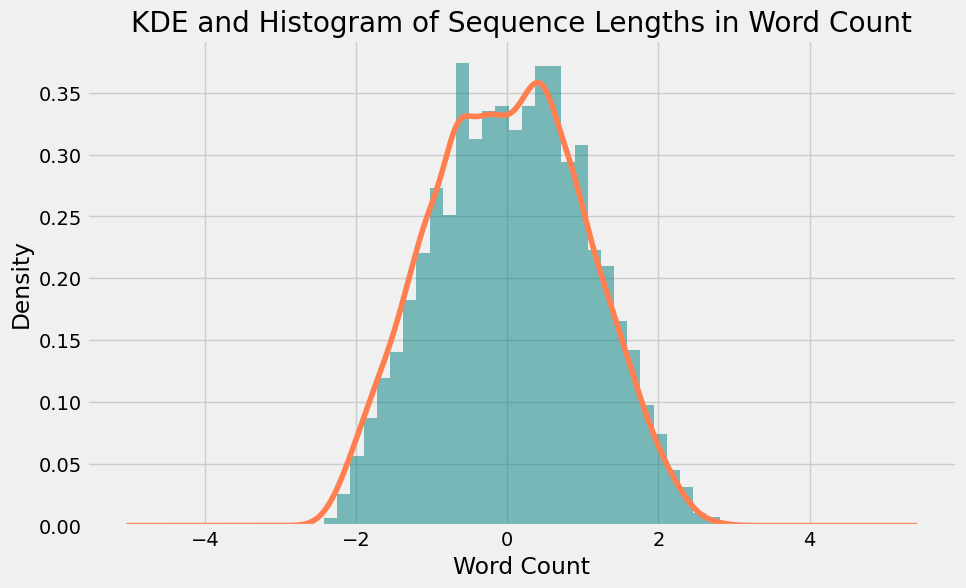

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

df['word_count'].plot(kind='kde', ax=ax, color='coral')
df['word_count'].hist(ax=ax, bins=30, alpha=0.5, color='teal', density=True)

plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('KDE and Histogram of Sequence Lengths in Word Count')
plt.show()

We can see here that our cut off point is around 30. We will be generous and pick 75 to account for the WordPiece tokenizer.

In [18]:
BATCH_SIZE = 32
MAX_LENGTH = 75

In the following cell, we are simply defining the different data loaders with their corresponding dataframes

In [19]:
train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE, numeric_columns)
test_data_loader = data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE, numeric_columns)
val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE, numeric_columns)

### Model Architecture
For this architecture we will be defining a couple of layers. We define a dropout layer which is a good parameter to tune for better results. We also define the ReLU activation function which is standard here. For our Fully-Connected layers we will have one for the BERT architecture. This layer takes in the token dimensions (1024 for large, 768 for base). We then define the layer for our numeric features and finally a layer for the combined outputs. 

In the forward calls, we take our BERT's output then pass it through the Linear, ReLU and Dropout layer. We then do the same for the numeric feature and finally concatenate them. We then pass these through our output layer and finally another dropout layer. I haven't played around withj this much but it's a pretty standard configuration. 

In [20]:
class BertClassifier(nn.Module):
    
    def __init__(self, model, num_classes, num_numerical, p=0.3):
        super(BertClassifier, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(p)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(num_numerical, 512)
        self.fc3 = nn.Linear(1024, 2)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.fc1(pooled_output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)
        return output
    
    def forward(self, input_ids, attention_mask, numerical_features):
        _, pooled_output = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        bert_output = self.fc1(pooled_output)
        bert_output = self.relu(bert_output)
        bert_output = self.dropout(bert_output)

        numeric_features_output = self.fc2(numerical_features)
        numeric_features_output = self.relu(numeric_features_output)
        numeric_features_output = self.dropout(numeric_features_output)

        combined_output = torch.cat((bert_output, numeric_features_output), dim=1)

        output = self.fc3(combined_output)
        output = self.dropout(output)
        return output

### Model Parameters, Loss Function and Optimizer
For the number of epochs we set it to a high number because we have early stopping implemented and will handle the stopping process. Fine-tuned models converge much quicker than normal Neural Networks so if you're not implementing early stopping somewhere around (3-7) iterations is usually good. The learning rate is something that I change a lot and you should experiment with some different ones. Generally it is reccomended to try (2e-5, 3e-5, 5e-5). We define the Adam loss function which is standard for pretty much every Neural Network. We are also using Cross Entropy for our loss function which is standard for Classification tasks. For the scheduler I am using get_linear_schedule_with_warmup from Transformers but have also experimented with ReduceLRUOnPlateau from Torch. This change requires you to change a couple of lines of code so I'd reccomend experimenting.

[🔝](#Table-of-Contents)

In [21]:
EPOCHS=5
LEARNING_RATE = 5e-5

NUM_CLASSES = len(classes)
bert_model = BertClassifier(model, NUM_CLASSES, len(numeric_columns)).to(device)

total_steps = len(train_data_loader)*EPOCHS

optimizer = optim.AdamW(params=bert_model.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()

warmup_steps = int(total_steps * 0.1)  

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

### Training and Evaluating
In the following code segments we implement a very standard training and evaluation loop. There's nothing special just keep in mind if you change the scheduler you will need to modify these. We have implemented early stopping which takes into account both Validation loss and accuracy. The combination of these helps mitigate scenarios where your overfitting hard but the validation accuracy slightly increases.

In [22]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, num_examples, device):
    model.train()  
    
    losses = []
    correct_preds = 0

    for data in data_loader:
        optimizer.zero_grad() 
        
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        numeric_features = data['numeric_features'].to(device)
        targets = data['target'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, numerical_features=numeric_features)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, targets)

        correct_preds += torch.sum(preds == targets).item()
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        scheduler.step()  
    
    return correct_preds / num_examples, np.mean(losses)


In [23]:
def evaluate(model, data_loader, loss_function, num_examples, device):
    model.eval() 
    
    losses = []
    correct_preds = 0  
    
    with torch.no_grad():  
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            numeric_features = data['numeric_features'].to(device)
            targets = data['target'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, numerical_features=numeric_features)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)
            
            correct_preds += torch.sum(preds == targets).item()  
            losses.append(loss.item()) 
    
    average_loss = np.mean(losses)
    accuracy = correct_preds / num_examples  
    
    return accuracy, average_loss


In [24]:
history = defaultdict(list)
best_accuracy = 0.0
best_loss = float('inf')  
patience_counter = 0
patience = 4

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}\n')
    
    train_accuracy, train_loss = train_epoch(
        bert_model.to(device),
        train_data_loader,
        loss_func,
        optimizer,
        scheduler,
        len(df_train),
        device
    )
    
    print(f'Train loss {train_loss} Accuracy: {train_accuracy}')
    
    val_accuracy, val_loss = evaluate(
        bert_model.to(device), 
        val_data_loader,
        loss_func, 
        len(df_val),
        device
    )
    
    print(f'Validation Loss {val_loss} Accuracy {val_accuracy}')
    
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(val_loss)
    
    if val_accuracy > best_accuracy or val_loss < best_loss:
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
        if val_loss < best_loss:
            best_loss = val_loss
        torch.save(bert_model.state_dict(), 'best_model.bin')
        patience_counter = 0  
        print("Validation performance improved, saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation performance for {patience_counter} epoch(s).")
    
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation performance.")
        break
        
#     scheduler.step()


Epoch 1/5

Train loss 0.5428651062605893 Accuracy: 0.725944170771757
Validation Loss 0.42294217894474667 Accuracy 0.8278580814717477
Validation performance improved, saving model.
Epoch 2/5

Train loss 0.41629052380616755 Accuracy: 0.8338259441707717
Validation Loss 0.38801730424165726 Accuracy 0.8488830486202366
Validation performance improved, saving model.
Epoch 3/5

Train loss 0.31407029462578406 Accuracy: 0.8791461412151067
Validation Loss 0.4248838971058528 Accuracy 0.8436268068331143
No improvement in validation performance for 1 epoch(s).
Epoch 4/5

Train loss 0.24579502337890147 Accuracy: 0.9082101806239737
Validation Loss 0.4721130517621835 Accuracy 0.8278580814717477
No improvement in validation performance for 2 epoch(s).
Epoch 5/5

Train loss 0.17100526995137724 Accuracy: 0.9310344827586207
Validation Loss 0.5967354848980904 Accuracy 0.8396846254927727
No improvement in validation performance for 3 epoch(s).


In [25]:
saved_model_path = 'best_model.bin'

bert_model.load_state_dict(torch.load(saved_model_path, map_location=device))

<All keys matched successfully>

In [26]:
test_accuracy,_ = evaluate(
    bert_model.to(device),
    test_data_loader,
    loss_func,
    len(df_test),
    device
)

In [27]:
def predict(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    actual = []
    
    with torch.no_grad():
        for data in data_loader:
            
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            numeric_features = data['numeric_features'].to(device)
            targets = data['target'].to(device)
            
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                numerical_features=numeric_features
            )
            
            _, preds = torch.max(outputs, dim=1)
            actual.extend(targets)
            prediction_probs.extend(outputs)
            predictions.extend(preds)
            
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    actual = torch.stack(actual)

    return predictions, prediction_probs, actual            

In [28]:
y_pred, y_pred_probs, y_test = predict(
    bert_model.to(device), 
    test_data_loader
)

In [29]:
print(classification_report(y_test.cpu(), y_pred.cpu(), target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.82      0.94      0.88       435
        Real       0.90      0.73      0.81       327

    accuracy                           0.85       762
   macro avg       0.86      0.83      0.84       762
weighted avg       0.86      0.85      0.85       762



### Submission
This part is a bit redundant but it's the easiest way I could think of to account for the missing target column in the submission set. We redefine our PyTorch dataset and Dataloader and remove the target parts. We then make predictions from our submission dataframe and submit.

[🔝](#Table-of-Contents)

In [30]:
class TweetsDataset(Dataset):
    def __init__(self,text, tokenizer, max_length, numeric):
        self.text = text
        self.tokenizer = tokenizer
        self.numeric = numeric
        self.max_length = max_length
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        item = self.text[idx]
        encoded = self.tokenizer.encode_plus(
            item,
            max_length=self.max_length,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        numeric = self.numeric[idx]
        
        return {
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'numeric_features': torch.tensor(numeric, dtype=torch.float)
        }
    
    
    
def data_loader(df, tokenizer, max_length, batches, numeric_features):
    dataset = TweetsDataset(
        text=df['text'].to_numpy(),
        tokenizer=tokenizer,
        max_length=max_length,
        numeric = df[numeric_features].to_numpy(dtype=float)
    )
    
    return DataLoader(
        dataset,
        batch_size=batches,
    )


def predict(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    
    with torch.no_grad():
        for data in data_loader:
            
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            numeric_features = data['numeric_features'].to(device)
            
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                numerical_features=numeric_features
            )
            
            _, preds = torch.max(outputs, dim=1)
            prediction_probs.extend(outputs)
            predictions.extend(preds)
            
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)

    return predictions, prediction_probs         

In [31]:
predictions, probabilities = predict(bert_model, data_loader(df_submit, tokenizer, max_length=100, batches=32, numeric_features=numeric_columns))
df_submit['target'] = predictions.cpu()

In [ ]:
df_submit[['id', 'target']].to_csv('submission.csv', index=False)